In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

ROOT = "."
SIM = 0 # choose
FIGURES_FOLDER = ROOT + f"/Figures/sim{SIM}/"
SIM_FOLDER = ROOT + f"/Simulations/sim{SIM}/"

if not os.path.exists(FIGURES_FOLDER):
    os.mkdir(FIGURES_FOLDER)
if not os.path.exists(SIM_FOLDER):
    os.mkdir(SIM_FOLDER)

In [4]:
def G(rho, p, P):
  return p*(1-rho/P)

# 2D parameter derivation:
# delta^2 / (4*tau) -> D for delta, tau -> 0
# Du = theta_u * D
# Di = theta_i * D

delta = 0.1 # mm
tau = 0.2 # h
D = delta**2/(4*tau)
Du = Di = 1.5e-3 # mm^2/h
theta_u = Du/D
theta_i = Di/D
q = 4.17e-2/5 # h-1
# q	= 4.17e-2 # h-1
p = 1.87e-2 # h-1
beta = q + np.sqrt(q**2+q*p) # h-1
# beta = 1.02e-1 # h-1
P = K = 1e4 # 1/mm^2
c_max = int(K*delta*delta)
Ru = Ri = 2.6 # mm
# Ri = 1 # mm
pop_unit = 4

print("q = ", q)
print("beta = ", beta)
print("u* = ", int(q*K/beta))
print("i* = ", int(p*K*(beta-q)/(beta*(beta+p))))

q =  0.00834
beta =  0.0233571102413214
u* =  3570
i* =  2858


In [5]:
def initialize_mesh(delta, Ru, Ri, c_max):
  initial_u = int(.9*c_max)
  initial_i = int(.1*c_max)
  size = int(1/delta * 10 * 2)
  domain = np.zeros((2, size, size),dtype='int16')
  for i in range(size):
    total_line = 0
    for j in range(size):
      if ((i-size/2)*delta)**2 + ((j-size/2)*delta)**2 <= (Ru)**2:
        domain[0][i][j] = initial_u
      if ((i-size/2)*delta)**2 + ((j-size/2)*delta)**2 <= (Ri)**2:
        domain[1][i][j] = initial_i
  return domain

domain = initialize_mesh(delta, Ru, Ri, c_max)

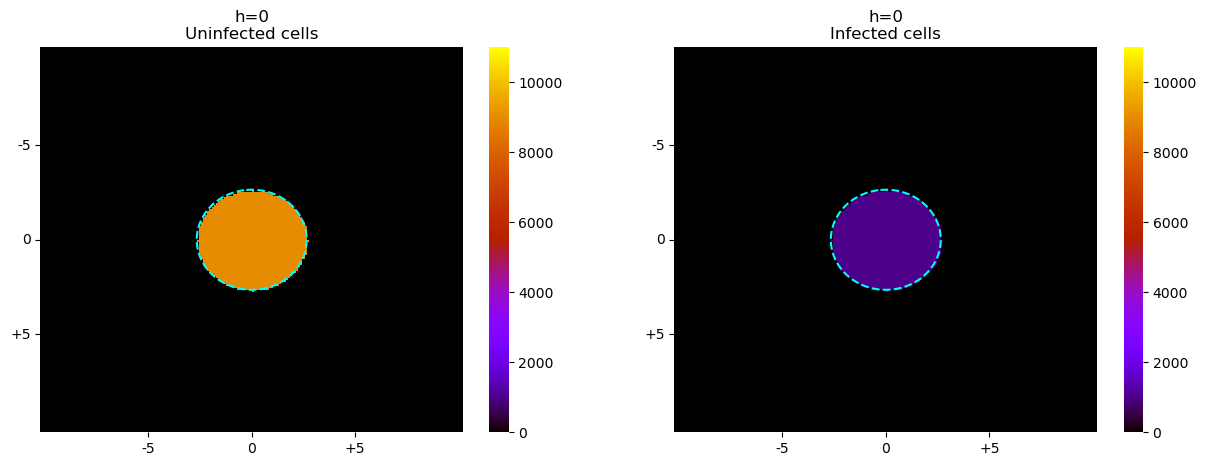

In [6]:
# define functions and parameters to save and plot results

def save_values(domain, h):
  np.save(f"{SIM_FOLDER}/sim{SIM}_h{h}.npy", domain)


def Circle(x, y, center):
  return (x-center)**2+(y-center)**2

size = int(1/delta * 10 * 2)
xx = np.linspace(0, size, size)
yy = np.linspace(0, size, size)
X, Y = np.meshgrid(xx,yy)
Z = Circle(X, Y, size//2)
ticks = [size//2 - 5//delta, size//2, size//2 + 5//delta]


def plot_domain(domain, h):
  radius_u = (Ru + h*np.sqrt(Du*p/2))/delta
  radius_i = Ri/delta
  plt.figure(figsize=(15, 5))

  # plot U
  plt.subplot(1, 2, 1)
  ax1 = sns.heatmap(np.divide(domain[0],delta**2),vmin=0,vmax=K*1.1,cmap="gnuplot")
  ax1.set_xticks(ticks)
  ax1.set_xticklabels(["-5","0","+5"],rotation=0)
  ax1.set_yticks(ticks)
  ax1.set_yticklabels(["-5","0","+5"],rotation=0)
  ax1.title.set_text(f"h={h}\nUninfected cells")
  ax1.contour(X,Y,Z,[radius_u**2],colors=["cyan"],linestyles=["dashed"])

  # plot I
  plt.subplot(1, 2, 2)
  ax2 = sns.heatmap(np.divide(domain[1],delta**2),vmin=0,vmax=K*1.1,cmap="gnuplot")
  ax2.set_xticks(ticks)
  ax2.set_xticklabels(["-5","0","+5"],rotation=0)
  ax2.set_yticks(ticks)
  ax2.set_yticklabels(["-5","0","+5"],rotation=0)
  ax2.title.set_text(f"h={h}\nInfected cells")
  ax2.contour(X,Y,Z,[radius_i**2],colors=["cyan"],linestyles=["dashed"])

  # save and plot figure
  plt.savefig(f"{FIGURES_FOLDER}/pressure_sim{SIM}_h{h}.png", format='png', dpi=1200)
  plt.show()

plot_domain(domain, 0)

In [7]:
# def simulation functions

def pressure_move(space_next, cell_type, i, j, p_unit):
  tot_cells_ij = space_next[0][i][j] + space_next[1][i][j]
  tot_cells_up = space_next[0][i-1][j] + space_next[1][i-1][j]
  tot_cells_down = space_next[0][i+1][j] + space_next[1][i+1][j]
  tot_cells_right = space_next[0][i][j+1] + space_next[1][i][j+1]
  tot_cells_left = space_next[0][i][j-1] + space_next[1][i][j-1]

  prob_up = max((tot_cells_ij-tot_cells_up), 0.)*theta_u/(4*c_max)
  prob_down = max((tot_cells_ij-tot_cells_down), 0.)*theta_u/(4*c_max)
  prob_right = max((tot_cells_ij-tot_cells_right), 0.)*theta_u/(4*c_max)
  prob_left = max((tot_cells_ij-tot_cells_left), 0.)*theta_u/(4*c_max)
  prob_stay = max(1-prob_right-prob_left-prob_up-prob_down, 0.)
  prob_dist = [prob_stay, prob_up, prob_down, prob_right, prob_left]
  prob_dist /= np.sum(prob_dist)

  action = np.random.choice(["stay", "up", "down", "right", "left"], p=prob_dist)
  if action == "up" and i > 0:
    space_next[cell_type][i][j] -= p_unit
    space_next[cell_type][i-1][j] += p_unit
  elif action == "down" and i < space_next.shape[1]:
    space_next[cell_type][i][j] -= p_unit
    space_next[cell_type][i+1][j] += p_unit
  elif action == "right" and j < space_next.shape[2]:
    space_next[cell_type][i][j] -= p_unit
    space_next[cell_type][i][j+1] += p_unit
  elif action == "left" and j > 0:
    space_next[cell_type][i][j] -= p_unit
    space_next[cell_type][i][j-1] += p_unit


def select_u_action(space, space_next, i, j):
  cell_type = 0
  # reproduce or die or nothing:
  if space[0][i][j]+space[1][i][j] >= c_max:
    prob_to_die = max(-tau*p*(1-(space[0][i][j]+space[1][i][j])/c_max), 0)
    prob_dist = [1-prob_to_die, prob_to_die]
    action = np.random.choice(["live","die"], p=prob_dist)
    if action == "die":
      space[0][i][j] -= pop_unit
      space_next[0][i][j] -= pop_unit
      return
  else:
    prob_to_reproduce = max(tau*p*(1-(space[0][i][j]+space[1][i][j])/c_max), 0)
    prob_dist = [1-prob_to_reproduce, prob_to_reproduce]
    action = np.random.choice(["nothing","reproduce"], p=prob_dist)
    if action == "reproduce":
      space_next[0][i][j] += pop_unit

  # infect or not
  prob_to_infect = tau*beta*space[1][i][j]/c_max
  prob_dist = [1-prob_to_infect, prob_to_infect]
  action = np.random.choice(["no","infected"], p=prob_dist)
  if action == "infected":
    space_next[0][i][j] -= pop_unit
    space_next[1][i][j] += pop_unit
    cell_type = 1

  # move or stay
  pressure_move(space_next, cell_type, i, j, pop_unit)

def select_i_action(space, space_next, i, j):
  cell_type = 1
  # live or die:
  prob_to_die = tau*q
  prob_dist = [1-prob_to_die, prob_to_die]
  action = np.random.choice(["live","die"], p=prob_dist)
  if action == "die":
    space_next[1][i][j] -= 1
    return

  # move or stay
  pressure_move(space_next, cell_type, i, j, 1)


def pressure_walk_2D(space, space_next, tot_hours, h=0):
  time_steps = int((tot_hours-h)/tau)
  for time in range(time_steps):
    for i in range(space.shape[1]):
      for j in range(space.shape[2]):
        for u_cell in range(space[0][i][j]//pop_unit):
          # select what happens to uninfected tumor cell
          select_u_action(space, space_next, i, j)
        for i_cell in range(space[1][i][j]):
          # select what happens to infected tumor cell
          select_i_action(space, space_next, i, j)
    space = space_next.copy()
    if (time+1) % int(1/tau) == 0:
      h += 1
      print(f"hour = {h:4} / {tot_hours}")
      if h % 10 == 0:
        plot_domain(space, h)
        save_values(space, h)
  return space

hour =    1 / 10
hour =    2 / 10
hour =    3 / 10
hour =    4 / 10
hour =    5 / 10
hour =    6 / 10
hour =    7 / 10
hour =    8 / 10
hour =    9 / 10
hour =   10 / 10


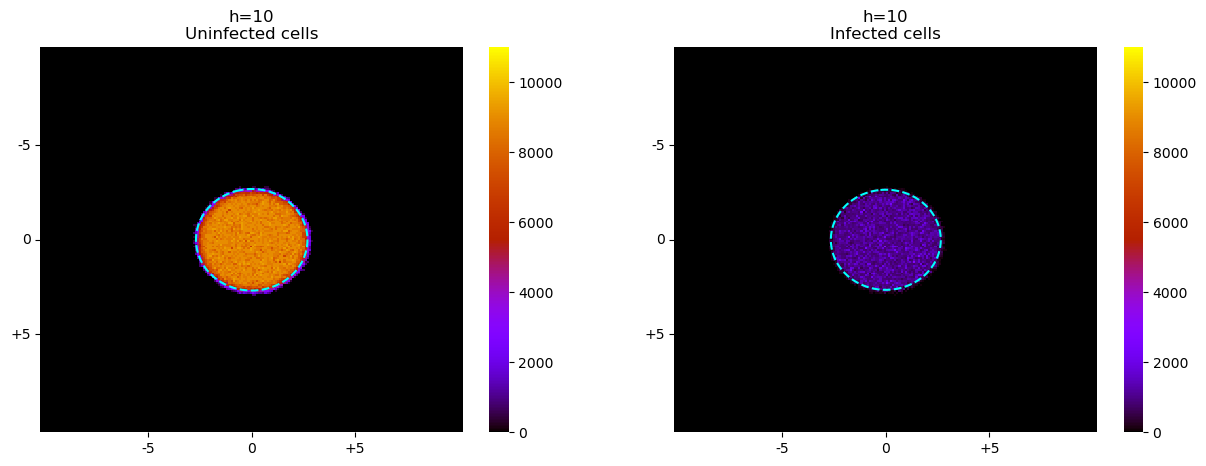

In [8]:
# simulate

## code to use in case of recovered simulation:
# rec_sim = SIM
# rec_h = 970
# domain = np.load(f"{SIM_FOLDER}/sim{rec_sim}/sim{rec_sim}_h{rec_h}.npy")
domain = pressure_walk_2D(domain, domain.copy(), tot_hours=10) # h=rec_h